In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('data.csv')

In [2]:
# Convert 'Inbetriebnahmedatum' to datetime to ensure date manipulation is possible if needed.
data['Inbetriebnahmedatum'] = pd.to_datetime(data['Inbetriebnahmedatum'])

# Filter out data by mandate flag and calculate the monthly average installations
monthly_data = data.groupby(['YearMonth', 'Bundesland', 'Mandate_Flag']).agg({'Count': 'sum'}).reset_index()
monthly_avg = monthly_data.groupby(['Bundesland', 'Mandate_Flag'])['Count'].mean().reset_index()

# Separate monthly averages for mandate flag 0 and 1
flag_0_avg = monthly_avg[monthly_avg['Mandate_Flag'] == 0].rename(columns={'Count': 'Avg_Count_Flag_0'})
flag_1_avg = monthly_avg[monthly_avg['Mandate_Flag'] == 1].rename(columns={'Count': 'Avg_Count_Flag_1'})

# Merge the monthly averages for mandate flags 0 and 1 to calculate percentage change for each state
merged_avg = pd.merge(flag_0_avg, flag_1_avg, on='Bundesland', how='inner')
merged_avg['Percentage_Change'] = ((merged_avg['Avg_Count_Flag_1'] - merged_avg['Avg_Count_Flag_0']) / 
                                   merged_avg['Avg_Count_Flag_0']) * 100

# For 'Permanent_Zero_Mandate', filter data where mandate flag is always 0 and calculate the monthly average
permanent_zero_mandate = data[data['Bundesland'] == 'Permanent_Zero_Mandate']
permanent_zero_avg = permanent_zero_mandate.groupby('YearMonth')['Count'].mean().reset_index(name='Avg_Count')

# Calculate the percentage change in monthly average for "Permanent_Zero_Mandate" in the same time frame
# Get time range based on available data in mandate flag 1 for comparability
mandate_period = data[data['Mandate_Flag'] == 1]['YearMonth'].unique()
permanent_zero_in_period = permanent_zero_avg[permanent_zero_avg['YearMonth'].isin(mandate_period)]
permanent_zero_before_period = permanent_zero_avg[~permanent_zero_avg['YearMonth'].isin(mandate_period)]

# Calculate averages before and during mandate periods
permanent_zero_before_avg = permanent_zero_before_period['Avg_Count'].mean()
permanent_zero_during_avg = permanent_zero_in_period['Avg_Count'].mean()

# Calculate the percentage change for "Permanent_Zero_Mandate"
permanent_zero_percentage_change = ((permanent_zero_during_avg - permanent_zero_before_avg) / 
                                    permanent_zero_before_avg) * 100

In [3]:
# Create a new DataFrame for control data using the Permanent_Zero_Mandate results
# Replicate the permanent_zero_percentage_change and average values for each state to create the '_control' rows.

# Extract the relevant average counts and percentage change from Permanent_Zero_Mandate
control_data = merged_avg[['Bundesland', 'Avg_Count_Flag_0', 'Avg_Count_Flag_1']].copy()
control_data['Bundesland'] = control_data['Bundesland'] + '_control'
control_data['Avg_Count_Flag_0'] = permanent_zero_before_avg
control_data['Avg_Count_Flag_1'] = permanent_zero_during_avg
control_data['Percentage_Change'] = permanent_zero_percentage_change

# Append the control data to the original table
final_table = pd.concat([merged_avg, control_data], ignore_index=True)

final_table

,Bundesland,Mandate_Flag_x,Avg_Count_Flag_0,Mandate_Flag_y,Avg_Count_Flag_1,Percentage_Change
0,Baden-Württemberg,0.0,1150.510870,1.0,10151.468750,782.344445
1,Bayern,0.0,2204.835079,1.0,15366.411765,596.941550
2,Berlin,0.0,42.671348,1.0,1119.428571,2523.372862
3,Brandenburg,0.0,346.530259,1.0,3282.000000,847.103438
4,Bremen,0.0,29.114286,1.0,430.666667,1379.228001
5,Hamburg,0.0,20.500000,1.0,486.045455,2270.953437
6,Hessen,0.0,477.032877,1.0,6108.571429,1180.534682
7,Niedersachsen,0.0,696.544199,1.0,11642.142857,1571.414804
8,Nordrhein-Westfalen,0.0,1687.129771,1.0,17485.444444,936.401867
9,Rheinland-Pfalz,0.0,432.580556,1.0,5292.000000,1123.355958


In [4]:
# Re-run the control calculation for each state individually with more robust handling

# Initialize an empty list to store control data for each state
control_data_list = []

# Loop through each state and calculate control values based on each state's mandate period
for state in merged_avg['Bundesland'].unique():
    # Filter data for the specific state
    state_data = data[data['Bundesland'] == state]
    
    # Identify the period when mandate flag is 1 for this state
    mandate_period_state = state_data[state_data['Mandate_Flag'] == 1]['YearMonth'].unique()
    
    # Calculate control data for the same period using "Permanent_Zero_Mandate"
    permanent_zero_state_in_period = permanent_zero_avg[permanent_zero_avg['YearMonth'].isin(mandate_period_state)]
    permanent_zero_state_before_period = permanent_zero_avg[~permanent_zero_avg['YearMonth'].isin(mandate_period_state)]
    
    # Calculate the before and during averages
    before_avg = permanent_zero_state_before_period['Avg_Count'].mean()
    during_avg = permanent_zero_state_in_period['Avg_Count'].mean()
    
    # Calculate the percentage change for control period
    percentage_change_control = ((during_avg - before_avg) / before_avg) * 100 if before_avg else 0
    
    # Append control data to the list
    control_data_list.append({
        'Bundesland': f"{state}_control",
        'Avg_Count_Flag_0': before_avg,
        'Avg_Count_Flag_1': during_avg,
        'Percentage_Change': percentage_change_control
    })

# Convert control data list to DataFrame
control_data_all_states = pd.DataFrame(control_data_list)

# Concatenate the control data with the original table
final_table_individual_control = pd.concat([merged_avg, control_data_all_states], ignore_index=True)

final_table_individual_control

,Bundesland,Mandate_Flag_x,Avg_Count_Flag_0,Mandate_Flag_y,Avg_Count_Flag_1,Percentage_Change
0,Baden-Württemberg,0.0,1150.510870,1.0,10151.468750,782.344445
1,Bayern,0.0,2204.835079,1.0,15366.411765,596.941550
2,Berlin,0.0,42.671348,1.0,1119.428571,2523.372862
3,Brandenburg,0.0,346.530259,1.0,3282.000000,847.103438
4,Bremen,0.0,29.114286,1.0,430.666667,1379.228001
5,Hamburg,0.0,20.500000,1.0,486.045455,2270.953437
6,Hessen,0.0,477.032877,1.0,6108.571429,1180.534682
7,Niedersachsen,0.0,696.544199,1.0,11642.142857,1571.414804
8,Nordrhein-Westfalen,0.0,1687.129771,1.0,17485.444444,936.401867
9,Rheinland-Pfalz,0.0,432.580556,1.0,5292.000000,1123.355958


In [5]:
# Separate the original and control data for plotting
original_data = final_table_individual_control[~final_table_individual_control['Bundesland'].str.contains('_control')]
control_data = final_table_individual_control[final_table_individual_control['Bundesland'].str.contains('_control')]

# Adjust the state names in control data to match original for a clearer plot
control_data['Bundesland'] = control_data['Bundesland'].str.replace('_control', '')

C:\Users\anton\AppData\Local\Temp\ipykernel_13384\2749196449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_data['Bundesland'] = control_data['Bundesland'].str.replace('_control', '')


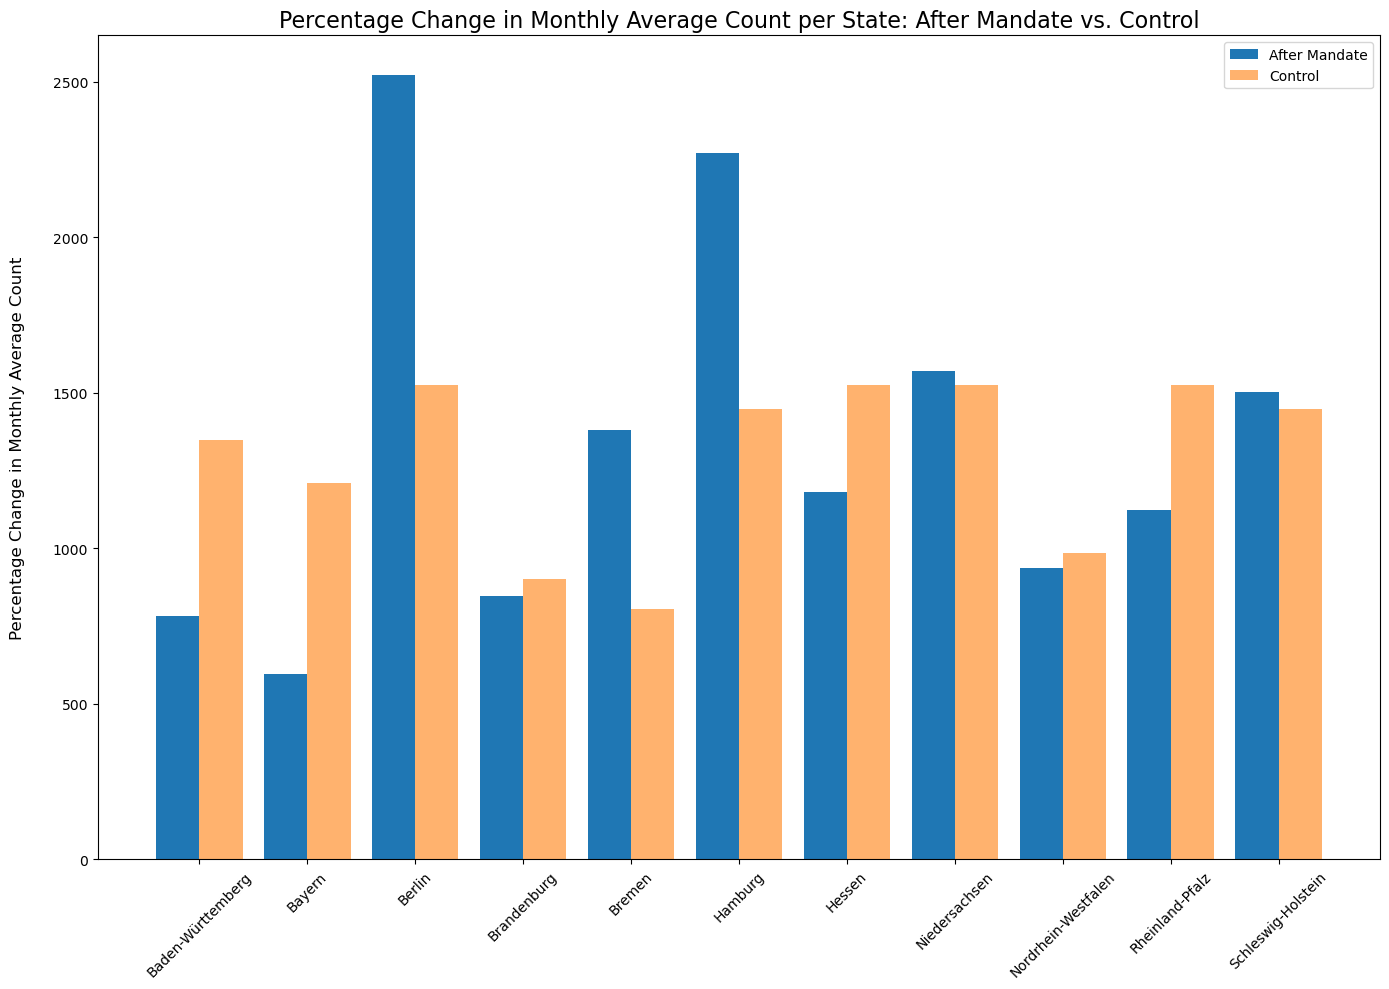

In [6]:
# Re-create the plot with separate bars for each state's original and control values

# Define bar width for better spacing between paired bars
bar_width = 0.4
states = original_data['Bundesland']

# Define positions for the bars
original_positions = range(len(states))
control_positions = [pos + bar_width for pos in original_positions]

# Plot the original and control values with separate bars for each state
plt.figure(figsize=(14, 10))
plt.bar(original_positions, original_data['Percentage_Change'], width=bar_width, label='After Mandate')
plt.bar(control_positions, control_data['Percentage_Change'], width=bar_width, label='Control', alpha=0.6)

# Set labels and title
plt.xlabel(None)
plt.ylabel('Percentage Change in Monthly Average Count', fontsize=12, labelpad=20)
plt.title('Percentage Change in Monthly Average Count per State: After Mandate vs. Control', fontsize=16)
plt.xticks([pos + bar_width / 2 for pos in original_positions], states, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('plots/control.png');

In [7]:
final_table_individual_control[['Bundesland','Avg_Count_Flag_0', 'Avg_Count_Flag_1', 'Percentage_Change']].round(1)

,Bundesland,Avg_Count_Flag_0,Avg_Count_Flag_1,Percentage_Change
0,Baden-Württemberg,1150.5,10151.5,782.3
1,Bayern,2204.8,15366.4,596.9
2,Berlin,42.7,1119.4,2523.4
3,Brandenburg,346.5,3282.0,847.1
4,Bremen,29.1,430.7,1379.2
5,Hamburg,20.5,486.0,2271.0
6,Hessen,477.0,6108.6,1180.5
7,Niedersachsen,696.5,11642.1,1571.4
8,Nordrhein-Westfalen,1687.1,17485.4,936.4
9,Rheinland-Pfalz,432.6,5292.0,1123.4


In [11]:
data

,Unnamed: 0,Inbetriebnahmedatum,Bundesland,Count,Cumulative_Count,Mandate_Flag,YearMonth
0,0,1991-01-02,Hamburg,1,1,0.0,1991-01
1,1,1991-01-09,Hamburg,1,2,0.0,1991-01
2,2,1991-01-17,Hamburg,1,3,0.0,1991-01
3,3,1991-01-20,Baden-Württemberg,1,1,0.0,1991-01
4,4,1991-01-25,Hessen,1,1,0.0,1991-01
...,...,...,...,...,...,...,...
115729,115729,2024-09-27,Permanent_Zero_Mandate,183,472716,NaN,2024-09
115730,115730,2024-09-28,Permanent_Zero_Mandate,101,472817,NaN,2024-09
115731,115731,2024-09-29,Permanent_Zero_Mandate,129,472946,NaN,2024-09
115732,115732,2024-09-30,Permanent_Zero_Mandate,122,473068,NaN,2024-09


In [33]:
d = data.loc[
    (data['Bundesland'].isin(['Baden-Württemberg', 'Permanent_Zero_Mandate'])) & 
    (data['Inbetriebnahmedatum'] < '2024-10-01')].groupby(['YearMonth', 'Bundesland'])['Count'].mean().to_frame('monthly_avg').reset_index()

In [29]:
d

,YearMonth,Bundesland,monthly_avg
0,1991-01,Baden-Württemberg,1.000000
1,1991-04,Permanent_Zero_Mandate,1.000000
2,1991-05,Baden-Württemberg,1.000000
3,1991-06,Baden-Württemberg,1.000000
4,1991-06,Permanent_Zero_Mandate,1.000000
...,...,...,...
792,2024-07,Permanent_Zero_Mandate,421.483871
793,2024-08,Baden-Württemberg,422.935484
794,2024-08,Permanent_Zero_Mandate,363.032258
795,2024-09,Baden-Württemberg,306.333333


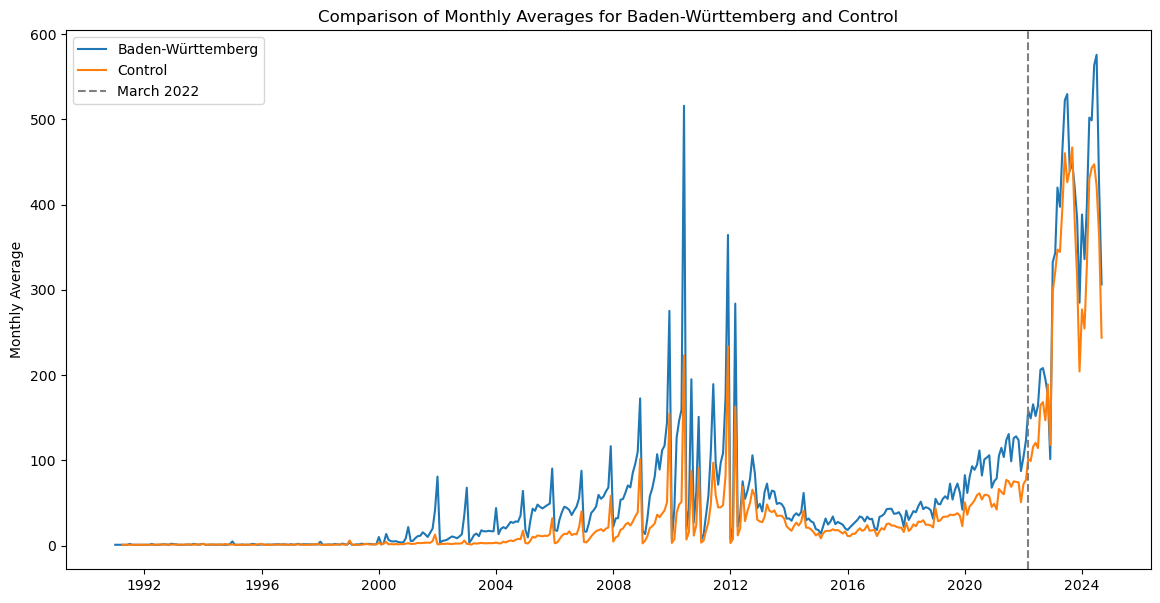

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

d['Bundesland'] = d['Bundesland'].replace('Permanent_Zero_Mandate', 'Control')

# Convert 'YearMonth' to datetime format for proper plotting
d['YearMonth'] = pd.to_datetime(d['YearMonth'], format='%Y-%m')

# Set plot style and dimensions
plt.figure(figsize=(14, 7))

# Plot data
sns.lineplot(data=d, x='YearMonth', y='monthly_avg', hue='Bundesland')

# Add vertical line for March 2022
plt.axvline(pd.to_datetime('2022-03-01'), color='gray', linestyle='--', label='March 2022')

# Label the plot
plt.title('Comparison of Monthly Averages for Baden-Württemberg and Control')
plt.xlabel(None)
plt.ylabel('Monthly Average')
plt.legend()

plt.savefig('plots/comparison_bw_control');